Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/09_Graph_Mining'
except ImportError as e:
    pass

## Exercise 9: Graph Mining

### 9.1. Node2Vec for Node Classification

#### 9.1.1 Load the CiteSeer dataset using the stellargraph dataset class

In [2]:
from stellargraph import datasets

dataset = datasets.CiteSeer()
G, node_subjects = dataset.load()

print(G.info())
print("\n\nnode subjects:")
print(node_subjects)

node_subjects.value_counts().to_frame()

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)
        Features: none


node subjects:
100157                  Agents
100598                      IR
105684                  Agents
11099                       DB
114091                      AI
                         ...  
zhang99query                DB
zhang99situated             ML
zhang99towards              IR
zhou00implementation        DB
455346                      ML
Name: subject, Length: 3312, dtype: object


,subject
DB,701
IR,668
Agents,596
ML,590
HCI,508
AI,249


#### 9.1.2 Generate the Random Walks and train a Node2Vec (Word2Vec) model using the gensim library

In [3]:
from stellargraph.data import BiasedRandomWalk

rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 33120


In [4]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]

model = Word2Vec(str_walks, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=20)

#### 9.1.3 Visualize the learned embeddings using t-SNE visualization.

In [5]:
from sklearn.manifold import TSNE

# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[node_id for node_id in node_ids]]

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


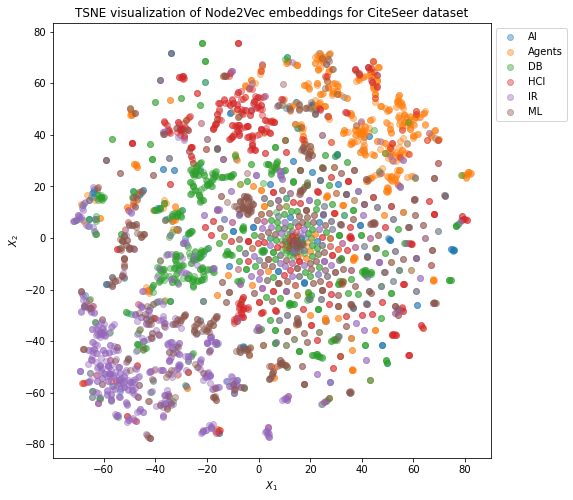

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

for target_value in np.unique(node_targets):
    rows_of_target_value = np.where(node_targets==target_value)
    ax.scatter(
        node_embeddings_2d[rows_of_target_value, 0],
        node_embeddings_2d[rows_of_target_value, 1],
        alpha=0.4,
        label=target_value
    )

ax.legend(bbox_to_anchor=(1,1));
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"TSNE visualization of Node2Vec embeddings for CiteSeer dataset",
);

#### 9.1.4 Perform a train/test split and learn a classifier for the nodes using their Node2Vec embeddings as feature input

In [7]:
from sklearn.model_selection import train_test_split

node_ids = node_subjects.index
targets = node_subjects.values

node_ids_train, node_ids_test, target_train, target_test = train_test_split(
    node_ids, targets, test_size=0.2, stratify=targets, random_state=42
)

X_train = [model.wv[x] for x in node_ids_train]
X_test = [model.wv[x] for x in node_ids_test]

In [8]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, target_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

#### 9.1.5 Evaluate the classifier on the split off test set using the Accuracy metric.

In [9]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(target_test, y_pred)

0.5535444947209653

### 9.2. Graph Neural Networks for Node Classification

#### 9.2.1 Further split the previous train set in train and validation and create a GCN model using Keras

In [10]:
node_ids_train, node_ids_val, target_train, target_val = train_test_split(
    node_ids_train, target_train, test_size=0.25, stratify=target_train, random_state=42
)
print(f"train: {len(target_train)} validation: {len(target_val)} test: {len(target_test)}")

train: 1986 validation: 663 test: 663


In [11]:
from sklearn.preprocessing import LabelBinarizer

target_encoding = LabelBinarizer()

enc_target_train = target_encoding.fit_transform(target_train)
enc_target_val = target_encoding.transform(target_val)
enc_target_test = target_encoding.transform(target_test)

In [12]:
from stellargraph.mapper import FullBatchNodeGenerator


generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(node_ids_train, enc_target_train)
val_gen = generator.flow(node_ids_val, enc_target_val)

Using GCN (local pooling) filters...


In [13]:
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, Model

gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)
x_inp, x_out = gcn.in_out_tensors()

predictions = layers.Dense(units=enc_target_train.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

#### 9.2.2 Train the model and evaluate on the test set. Can the GCN improve over the Node2Vec approach?

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.7926 - acc: 0.1425 - val_loss: 1.7417 - val_acc: 0.3756 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 1.7326 - acc: 0.3313 - val_loss: 1.6495 - val_acc: 0.4178 - 271ms/epoch - 271ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6341 - acc: 0.4074 - val_loss: 1.5476 - val_acc: 0.4676 - 277ms/epoch - 277ms/step
Epoch 4/200
1/1 - 0s - loss: 1.5293 - acc: 0.4366 - val_loss: 1.4506 - val_acc: 0.5566 - 283ms/epoch - 283ms/step
Epoch 5/200
1/1 - 0s - loss: 1.4296 - acc: 0.5070 - val_loss: 1.3547 - val_acc: 0.6305 - 286ms/epoch - 286ms/step
Epoch 6/200
1/1 - 0s - loss: 1.3265 - acc: 0.5871 - val_loss: 1.2676 - val_acc: 0.6667 - 270ms/epoch - 270ms/step
Epoch 7/200
1/1 - 0s - loss: 1.2347 - acc: 0.6410 - val_loss: 1.1893 - val_acc: 0.6938 - 275ms/epoch - 275ms/step
Epoch 8/200
1/1 - 0s - loss: 1.1477 - acc: 0.6591 - val_loss: 1.1166 - val_acc: 0.7210 - 276ms/epoch - 276ms/step
Epoch 9/200
1/1 - 0s - loss: 1.0656 - acc: 0.6903 - val_loss: 1.0504 - val_acc: 0.7315 - 271ms

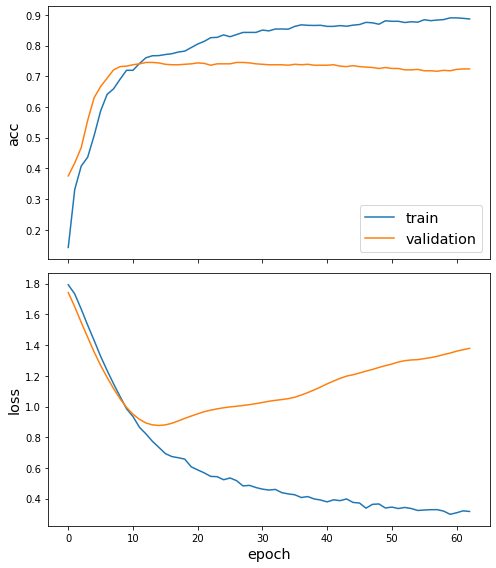

In [15]:
import stellargraph as sg
sg.utils.plot_history(history)

In [16]:
test_gen = generator.flow(node_ids_test, enc_target_test)

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 100ms/step - loss: 0.8191 - acc: 0.7572

Test Set Metrics:
	loss: 0.8191
	acc: 0.7572


#### 9.2.3 Visualize the embedded Nodes by extracting the embeddings of the last Convolution Layer and visualizing them using t-SNE.

In [17]:
all_gen = generator.flow(node_ids)

embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 3312, 16)

In [18]:
X = emb.squeeze(0)

trans = TSNE(n_components=2) # TSNE can be replaced by PCA 
X_reduced = trans.fit_transform(X)
X_reduced.shape

C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(3312, 2)

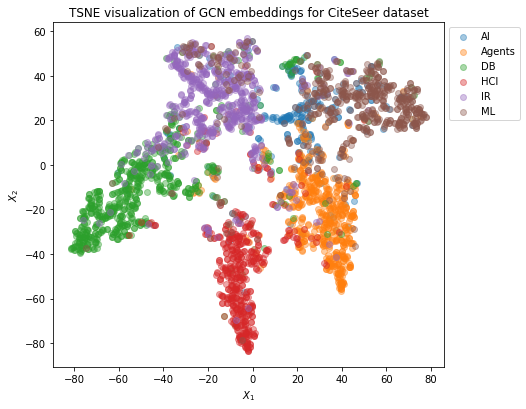

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))

for target_value in np.unique(targets):
    rows_of_target_value = np.where(targets==target_value)
    ax.scatter(
        X_reduced[rows_of_target_value, 0],
        X_reduced[rows_of_target_value, 1],
        alpha=0.4,
        label=target_value
    )

ax.legend(bbox_to_anchor=(1,1));
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"TSNE visualization of GCN embeddings for CiteSeer dataset",
);